# Test of Mean Reversion Strategy (strategy 8) via Backtest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [56]:
import sys, importlib
proj_dir = r"D:\Projects\Backtest"
if proj_dir not in sys.path:
    sys.path.insert(0, proj_dir)

# Import the MODULE objects
import DataLoader as dlmod
import Strategy as strmod
import strategy8 as s8mod
import Portfolio as pmod
import Backtest as btmod

# Confirm we’re pointing at the right files
print(dlmod.__file__)

# When you edit files, reload the MODULES (not the classes)
importlib.reload(dlmod)
importlib.reload(strmod)
importlib.reload(s8mod)
importlib.reload(pmod)
importlib.reload(btmod)

# (Re)grab class names from the freshly reloaded modules
DataLoader = dlmod.DataLoader
Strategy = strmod.Strategy
Strategy8_1 = s8mod.Strategy8_1
Strategy8_2 = s8mod.Strategy8_2
Strategy8_3 = s8mod.Strategy8_3
Strategy8_4 = s8mod.Strategy8_4
Strategy8_2_Improved = s8mod.Strategy8_2_Improved
Portfolio = pmod.Portfolio
CostModel = pmod.CostModel
ExitPolicy = pmod.ExitPolicy
ExecutionPolicy = pmod.ExecutionPolicy
Backtester = btmod.Backtester

d:\Projects\Strategy_Backtest\Backtest\DataLoader.py


In [57]:
import matplotlib.pyplot as plt

# Dataloader

In [25]:
# Load data (adjust paths/columns as needed)
dl = DataLoader(
    filepath= r'D:\CTA\k线数据\data5m\F1-2y.csv',      # or .parquet
    date_col= "open_time",                 # column with timestamps
    cols_to_keep=None,          # we only need close for Strategy8
    unit= 'ms',                    # e.g., 'ms' if date_col is in milliseconds since epoch; optional
    tz=None,
    expected_freq="5T"               # e.g., 5-minute data; optional
)
df = dl.load()

In [26]:
print({k: df.attrs[k] for k in ['expected_freq','n_duplicate_index_dropped','n_bad_intervals']})


{'expected_freq': '5T', 'n_duplicate_index_dropped': 25701, 'n_bad_intervals': 796}


In [27]:
df['avg_price'] = 0.25*(df['open'] + df['high'] + df['low'] + df['close'])
df

,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore,avg_price
open_time,,,,,,,,,,,,
2020-10-01 00:00:00,0.10138,0.10167,0.10131,0.10137,1549123,1.601511e+12,1.571566e+05,635,787053,7.986729e+04,0,0.101433
2020-10-01 00:05:00,0.10142,0.10154,0.10111,0.10126,1380494,1.601511e+12,1.398637e+05,509,518337,5.254580e+04,0,0.101333
2020-10-01 00:10:00,0.10127,0.10167,0.10122,0.10153,874090,1.601511e+12,8.870951e+04,551,425712,4.319628e+04,0,0.101422
2020-10-01 00:15:00,0.10152,0.10272,0.10152,0.10263,4317173,1.601512e+12,4.409095e+05,1903,3138641,3.205755e+05,0,0.102098
2020-10-01 00:20:00,0.10263,0.10302,0.10245,0.10265,3421695,1.601512e+12,3.516648e+05,1385,1767351,1.817429e+05,0,0.102688
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 23:35:00,0.44840,0.44840,0.44630,0.44660,3970573,1.656632e+12,1.777002e+06,2204,1921897,8.602324e+05,0,0.447425
2022-06-30 23:40:00,0.44660,0.44910,0.44650,0.44800,3065405,1.656633e+12,1.373151e+06,2017,1446156,6.476370e+05,0,0.447550
2022-06-30 23:45:00,0.44790,0.45420,0.44740,0.45410,10839258,1.656633e+12,4.891352e+06,6548,6539383,2.951120e+06,0,0.450900


In [28]:
df.index.duplicated().sum()

0

# Strategy 

In [29]:
str8_1 = Strategy8_1(window=10000,            # lookback bars
    threshold_pct=0.1,      # trigger threshold
    hold_minutes=120,      # holding horizon in minutes
    interval_minutes=5,    # bar size in minutes
    price_col="close", 
)
sig8_1 = str8_1.signal(df)
sig8_1[sig8_1.entry!=0]

,entry,exit,side
open_time,,,
2020-11-18 05:30:00,1.0,0.0,1.0
2020-11-18 05:45:00,1.0,0.0,1.0
2020-11-21 02:55:00,1.0,0.0,1.0
2020-11-21 04:05:00,1.0,0.0,1.0
2020-11-21 17:20:00,1.0,0.0,1.0
...,...,...,...
2022-05-12 03:50:00,1.0,0.0,1.0
2022-05-12 03:55:00,1.0,0.0,1.0
2022-05-12 04:20:00,1.0,0.0,1.0


In [75]:
str8_2 = Strategy8_2_Improved(
    window=10000,            # lookback bars
    threshold_pct=0.1,      # trigger threshold
    hold_minutes=120,      # holding horizon in minutes
    interval_minutes=5,    # bar size in minutes
    price_col="close",
    hard_drop= 0.05,
    k_std = 5, 
)
sig8_2_improved = str8_2.signal(df)

In [74]:
sig8_2_improved[sig8_2_improved.entry != 0 ]

,entry,exit,side
open_time,,,
2020-11-23 13:15:00,1.0,0.0,1.0
2020-11-24 06:05:00,1.0,0.0,1.0
2020-12-01 12:25:00,1.0,0.0,1.0
2020-12-23 22:10:00,1.0,0.0,1.0
2021-02-10 12:35:00,1.0,0.0,1.0
2021-02-15 02:30:00,1.0,0.0,1.0
2021-02-20 22:40:00,1.0,0.0,1.0
2021-02-22 14:10:00,1.0,0.0,1.0
2021-02-23 09:05:00,1.0,0.0,1.0


# Cost Model, Exit Policy, Excuation Policy, And Portfolio

In [30]:
cost_model = CostModel(
    fee_bps=0.0,               # 0.5 bps commission/fees
    slip_bps=0.0               # 1.0 bps slippage
)

In [31]:
exit_policy1 = ExitPolicy(
    stop_loss_pct=None,        # 2% protective stop
    take_profit_pct=None,      # 3% profit target
    max_hold_bars=None          # no max hold limit
)

## Strategy 8 1 

In [32]:
sig8_1[sig8_1.entry != 0 ]

,entry,exit,side
open_time,,,
2020-11-18 05:30:00,1.0,0.0,1.0
2020-11-18 05:45:00,1.0,0.0,1.0
2020-11-21 02:55:00,1.0,0.0,1.0
2020-11-21 04:05:00,1.0,0.0,1.0
2020-11-21 17:20:00,1.0,0.0,1.0
...,...,...,...
2022-05-12 03:50:00,1.0,0.0,1.0
2022-05-12 03:55:00,1.0,0.0,1.0
2022-05-12 04:20:00,1.0,0.0,1.0


In [41]:
# this is used for strategy 8.1 
# the entry confilict is set to 'extend' to extend the holding period if a new entry signal is received
# exit scope is set to "side"
# 
exec_policy = ExecutionPolicy(
    trade_lag=1,               # enter/exit on next bar
    bound=1.0,                 # position sizing cap (1.0 = 100% of equity if that’s your convention)
    entry_conflict="extend",   # 'ignore',  'extend', 'pyramid', 'flip'
    fixed_hold_bars= 24,     # fixed holding period in bars, we need to set this when using extend mode
    exit_scope="side",         # 'all', 'side'
    lot_size=1.0,              # trade in multiples of 1.0 lots
    exit_lot_policy='fifo',    # 'fifo', 
    exit_lot_count=1,           # number of lots to exit on each exit signal
    exit_policy= exit_policy1
)

In [42]:
port_8_1 = Portfolio(
    initial_equity=1,
    price_col="avg_price", # the price column to use for PnL calculations
    allow_short=False,
    cost=cost_model,
    exec=exec_policy
)

In [43]:
ledger, trade_log = port_8_1.run(df, sig8_1)

In [44]:
ledger

,price,position,turnover,ret_asset,cost_rate,ret_net,equity_additive,drawdown_additive,equity_compound,drawdown_compound
open_time,,,,,,,,,,
2020-10-01 00:00:00,0.101433,0.0,0.0,0.000000,0.0,0.0,1.000000,0.000000,1.000000,0.000000
2020-10-01 00:05:00,0.101333,0.0,0.0,-0.000986,0.0,0.0,1.000000,0.000000,1.000000,0.000000
2020-10-01 00:10:00,0.101422,0.0,0.0,0.000888,0.0,0.0,1.000000,0.000000,1.000000,0.000000
2020-10-01 00:15:00,0.102098,0.0,0.0,0.006655,0.0,0.0,1.000000,0.000000,1.000000,0.000000
2020-10-01 00:20:00,0.102688,0.0,0.0,0.005779,0.0,0.0,1.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2022-06-30 23:35:00,0.447425,0.0,0.0,0.003476,0.0,0.0,2.333056,-0.008288,3.418504,-0.019497
2022-06-30 23:40:00,0.447550,0.0,0.0,0.000279,0.0,0.0,2.333056,-0.008288,3.418504,-0.019497
2022-06-30 23:45:00,0.450900,0.0,0.0,0.007485,0.0,0.0,2.333056,-0.008288,3.418504,-0.019497


In [45]:
trade_log

,entry_time,entry_price,exit_time,exit_price,side,qty,bars_held,pnl,exit_reason
0,2020-11-18 05:35:00,0.107755,2020-11-18 07:50:00,0.106362,1,1.0,27,-0.012923,scheduled_exit
1,2020-11-21 03:00:00,0.119350,2020-11-21 06:10:00,0.121900,1,1.0,38,0.021366,scheduled_exit
2,2020-11-21 17:25:00,0.126567,2020-11-21 19:25:00,0.127897,1,1.0,24,0.010508,scheduled_exit
3,2020-11-22 00:25:00,0.136963,2020-11-22 03:40:00,0.128607,1,1.0,39,-0.061002,scheduled_exit
4,2020-11-22 06:25:00,0.121995,2020-11-22 08:25:00,0.133700,1,1.0,24,0.095947,scheduled_exit
...,...,...,...,...,...,...,...,...,...
67,2022-05-11 12:35:00,0.594925,2022-05-11 15:55:00,0.571275,1,1.0,40,-0.039753,scheduled_exit
68,2022-05-11 20:55:00,0.502075,2022-05-11 22:55:00,0.519275,1,1.0,24,0.034258,scheduled_exit
69,2022-05-12 03:55:00,0.448875,2022-05-12 06:25:00,0.425450,1,1.0,30,-0.052186,scheduled_exit
70,2022-06-15 18:05:00,0.469125,2022-06-15 20:05:00,0.515225,1,1.0,24,0.098268,scheduled_exit


## Strategy 8 2 improved

In [69]:
# this is used for strategy 8.2 and 8.2 improved 
# the entry confilict is set to pyramid to allow multiple entries
# exit scope is set to "side"
# lot_size is set to 1.0 i.e. trade in multiples of 1.0 lots
# exit_lot_policy is set to 'fifo' i.e. the exit event will close the oldest position first
# exit_lot_count is set to 1 i.e. the exit event will close one lot at a time
exec_policy1 = ExecutionPolicy(
    trade_lag=1,               # enter/exit on next bar
    bound=1.0,                 # position sizing cap (1.0 = 100% of equity if that’s your convention)
    entry_conflict="pyramid",  # pyramid entries
    fixed_hold_bars = None,      # hold for 24 bars
    exit_scope = "side",       # exit on opposite signal
    lot_size=1.0,               # trade in multiples of 1.0 lots
    exit_lot_policy = "fifo", 
    exit_lot_count = 1,
    exit_policy=exit_policy1
)

In [70]:
port_8_2 = Portfolio(
    initial_equity=1,
    price_col="avg_price", # the price column to use for PnL calculations
    allow_short=False,
    cost=cost_model,
    exec=exec_policy1
)

In [ ]:
ledger, trade_log = port_8_2.run(df, sig8_2_improved)

In [16]:
ledger

,price,position,turnover,ret_asset,cost_rate,ret_net,equity_additive,drawdown_additive,equity_compound,drawdown_compound
open_time,,,,,,,,,,
2020-10-01 00:00:00,0.101433,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,1.000000,0.0
2020-10-01 00:05:00,0.101333,0.0,0.0,-0.000986,0.0,0.0,1.000000,0.0,1.000000,0.0
2020-10-01 00:10:00,0.101422,0.0,0.0,0.000888,0.0,0.0,1.000000,0.0,1.000000,0.0
2020-10-01 00:15:00,0.102098,0.0,0.0,0.006655,0.0,0.0,1.000000,0.0,1.000000,0.0
2020-10-01 00:20:00,0.102688,0.0,0.0,0.005779,0.0,0.0,1.000000,0.0,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-06-30 23:35:00,0.447425,0.0,0.0,0.003476,0.0,0.0,3.992429,0.0,15.448812,0.0
2022-06-30 23:40:00,0.447550,0.0,0.0,0.000279,0.0,0.0,3.992429,0.0,15.448812,0.0
2022-06-30 23:45:00,0.450900,0.0,0.0,0.007485,0.0,0.0,3.992429,0.0,15.448812,0.0


In [650]:
ledger[ledger['position'] != 0]

,price,position,turnover,ret_asset,cost_rate,ret_net,equity_additive,drawdown_additive,equity_compound,drawdown_compound
open_time,,,,,,,,,,
2020-11-18 05:35:00,0.107755,1.0,1.0,-0.014834,0.0,0.0,1.000000,0.00000,1.000000,0.00000
2020-11-18 05:40:00,0.106620,1.0,0.0,-0.010533,0.0,0.0,1.000000,0.00000,1.000000,0.00000
2020-11-18 05:45:00,0.104447,1.0,0.0,-0.020376,0.0,0.0,1.000000,0.00000,1.000000,0.00000
2020-11-18 05:50:00,0.104498,2.0,1.0,0.000479,0.0,0.0,1.000000,0.00000,1.000000,0.00000
2020-11-18 05:55:00,0.104547,2.0,0.0,0.000478,0.0,0.0,1.000000,0.00000,1.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...
2022-06-18 08:30:00,0.460350,1.0,0.0,0.007716,0.0,0.0,4.625449,-0.02304,27.065041,-0.11584
2022-06-18 08:35:00,0.457675,1.0,0.0,-0.005811,0.0,0.0,4.625449,-0.02304,27.065041,-0.11584
2022-06-18 08:40:00,0.457200,1.0,0.0,-0.001038,0.0,0.0,4.625449,-0.02304,27.065041,-0.11584


In [ ]:
port_8_2._trade_log

,entry_time,entry_price,exit_time,exit_price,side,qty,bars_held,pnl,exit_reason
0,2020-11-18 05:35:00,0.107755,2020-11-18 07:35:00,0.105673,1,1.0,24,-0.019326,event_exit
1,2020-11-18 05:50:00,0.104498,2020-11-18 07:50:00,0.106362,1,1.0,24,0.017847,event_exit
2,2020-11-21 03:00:00,0.119350,2020-11-21 05:00:00,0.118107,1,1.0,24,-0.010411,event_exit
3,2020-11-21 04:10:00,0.117112,2020-11-21 06:10:00,0.121900,1,1.0,24,0.040879,event_exit
4,2020-11-21 17:25:00,0.126567,2020-11-21 19:25:00,0.127897,1,1.0,24,0.010508,event_exit
...,...,...,...,...,...,...,...,...,...
108,2022-05-12 03:55:00,0.448875,2022-05-12 05:55:00,0.409050,1,1.0,24,-0.088722,event_exit
109,2022-05-12 04:00:00,0.439950,2022-05-12 06:00:00,0.411875,1,1.0,24,-0.063814,event_exit
110,2022-05-12 04:25:00,0.434900,2022-05-12 06:25:00,0.425450,1,1.0,24,-0.021729,event_exit
111,2022-06-15 18:05:00,0.469125,2022-06-15 20:05:00,0.515225,1,1.0,24,0.098268,event_exit


In [652]:
(ledger.index[-1] - ledger.index[0])/pd.Timedelta('1 day')/365

1.747935692541857

# Backtest 

## Strategy 8 1

In [58]:
bt_8_1 = Backtester(
    asset_name="F1",
    df=df,
    portfolio=port_8_1,
    periods_per_year=252*24*12
)

In [59]:
str8_1_res = bt_8_1.run(str8_1, 'MeanReversionCTA8.1')

In [60]:
[key for key in str8_1_res.keys()]

['name', 'summary', 'signals', 'ledger', 'trade_log', 'ret_trade_desc']

In [61]:
str8_1_res['ret_trade_desc']

count    72.000000
mean      0.018515
std       0.052713
min      -0.093200
25%      -0.008465
50%       0.010827
75%       0.037890
max       0.236841
Name: pnl, dtype: float64

In [62]:
str8_1_res['summary']

{'CAGR_add': 0.3974152246388709,
 'CAGR_comp': 0.6250174430454627,
 'AnnReturn': 0.5265362632325294,
 'AnnVol': 0.2960906774438286,
 'Sharpe': 1.6769736471244603,
 'MaxDD_add': -0.13406255794573851,
 'MaxDD_comp': -0.16956243124356707,
 'AvgTurnover': 0.0007836990595611285,
 'NumTrades': 72,
 'WinRate': 0.5972222222222222,
 'AvgWin': 0.047189383546305946,
 'AvgLoss': -0.024003013706269484,
 'PnlRatio': 1.965977444489826,
 'MaxSingleLoss': -0.09319995210467324}

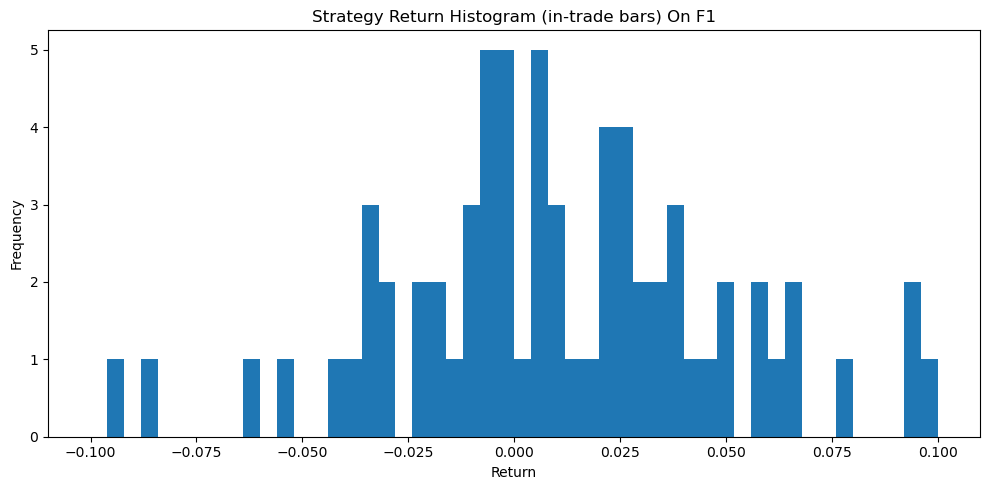

In [63]:
bt_8_1.plot_return_histogram(str8_1_res, bins = 50, abs_range =0.1)

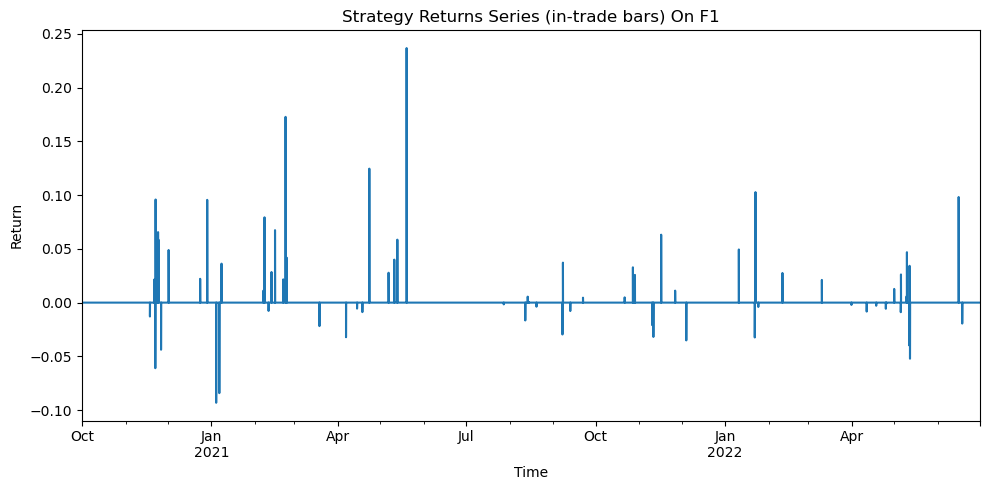

In [64]:
bt_8_1.plot_return_timeseries(str8_1_res)

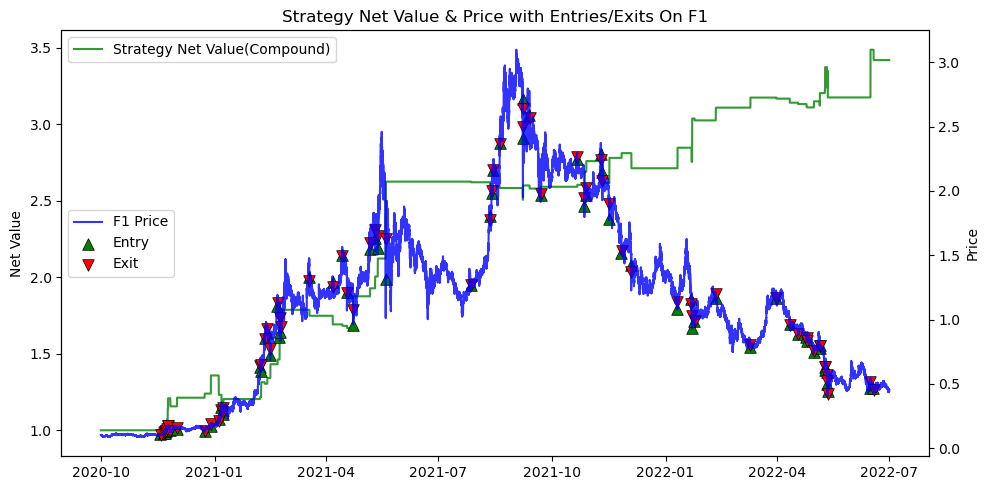

In [65]:
bt_8_1.plot_equity_and_price(str8_1_res, price_col='close', method='compound')

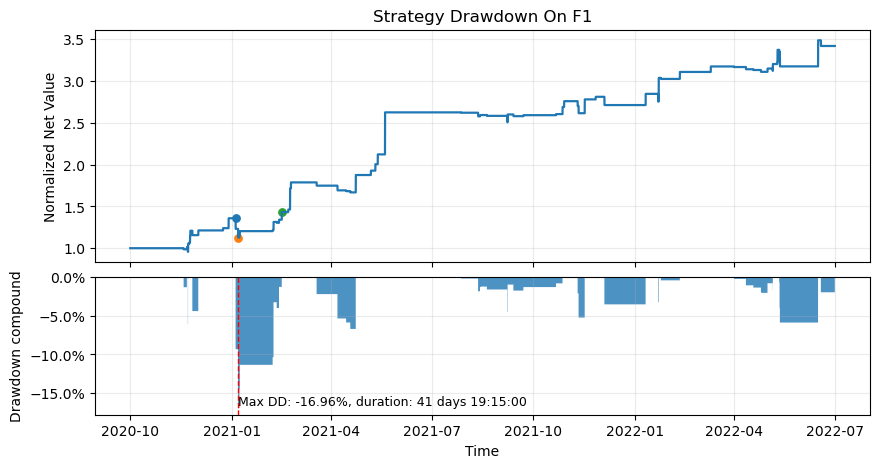

In [66]:
bt_8_1.plot_drawdown(str8_1_res, method='compound')

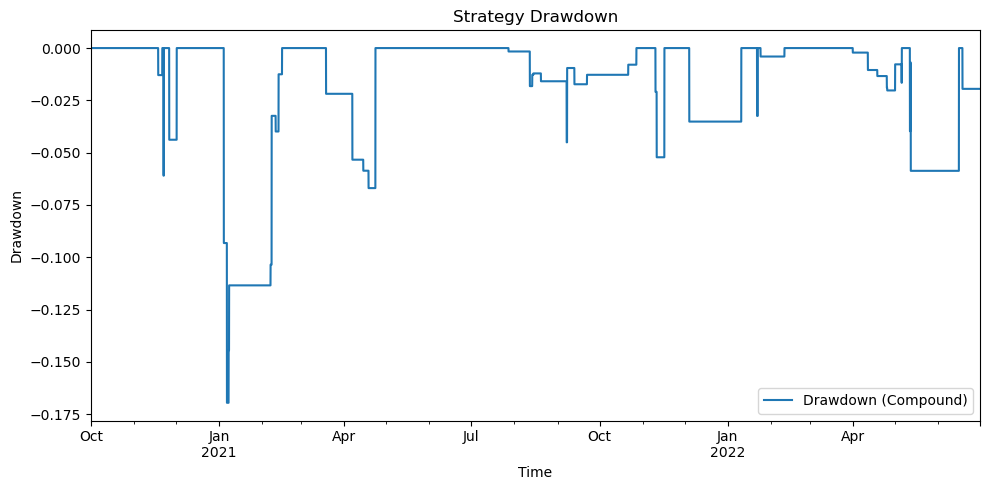

In [67]:
bt_8_1.plot_drawdown_simple(str8_1_res, method='compound')

## Strategy 8 2 improved

In [71]:
bt_8_2 = Backtester(
    asset_name="F1",
    df=df,
    portfolio=port_8_2,
    periods_per_year=252*24*12
)

In [76]:
str8_2_res = bt_8_2.run(str8_2, 'MeanReversionCTA8.2 Improved')

In [79]:
[key for key in str8_2_res.keys()]

['name', 'summary', 'signals', 'ledger', 'trade_log', 'ret_trade_desc']

In [80]:
str8_2_res['ret_trade_desc']

count    29.000000
mean      0.103187
std       0.102121
min      -0.021861
25%       0.041642
50%       0.075202
75%       0.113276
max       0.431735
Name: pnl, dtype: float64

In [81]:
str8_2_res['summary']

{'CAGR_add': 0.7277486234327792,
 'CAGR_comp': 1.9484751977666175,
 'AnnReturn': 1.1819624813296183,
 'AnnVol': 0.48711673184111237,
 'Sharpe': 2.3648591929405645,
 'MaxDD_add': -0.013517299710981368,
 'MaxDD_comp': -0.021861072835200113,
 'AvgTurnover': 0.0003156565656565657,
 'NumTrades': 29,
 'WinRate': 0.9310344827586207,
 'AvgWin': 0.11218155141591557,
 'AvgLoss': -0.01823653322538299,
 'PnlRatio': 6.151473530055196,
 'MaxSingleLoss': -0.021861072835200113}

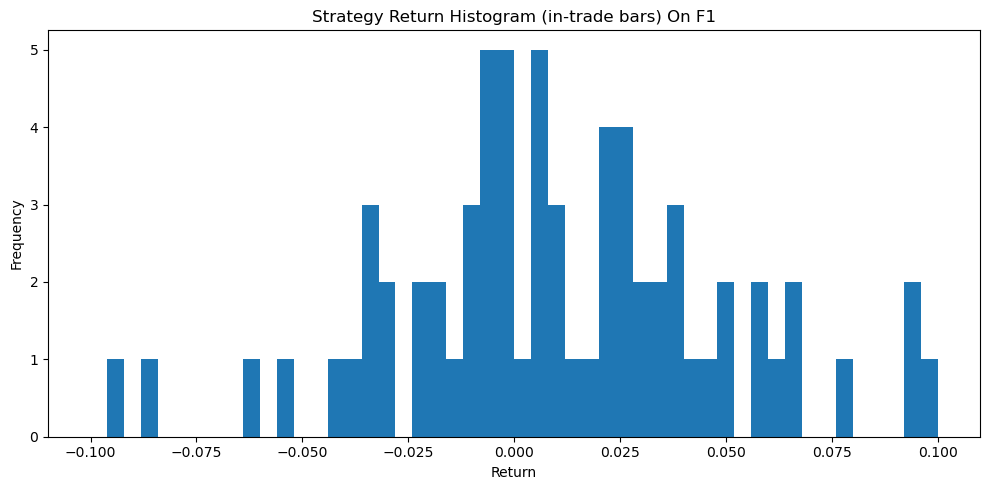

In [82]:
bt_8_2.plot_return_histogram(str8_1_res, bins = 50, abs_range =0.1)

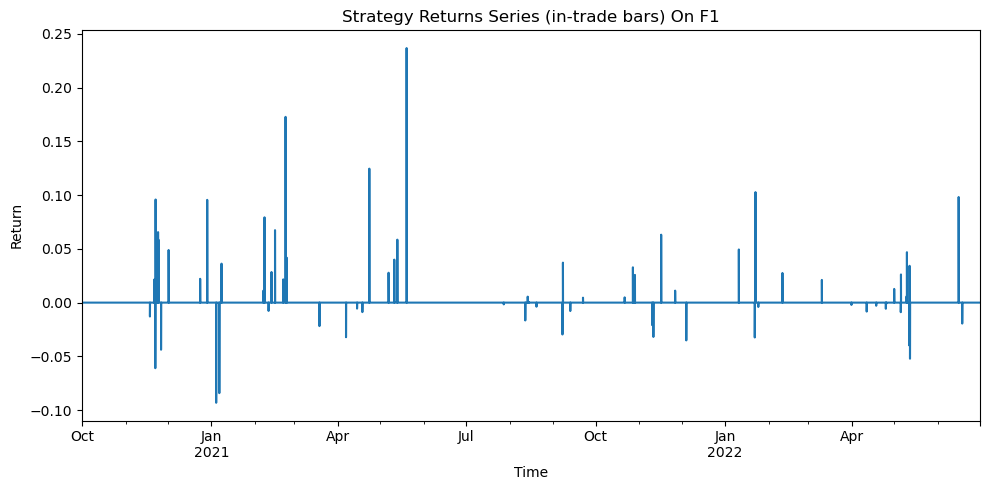

In [83]:
bt_8_2.plot_return_timeseries(str8_1_res)

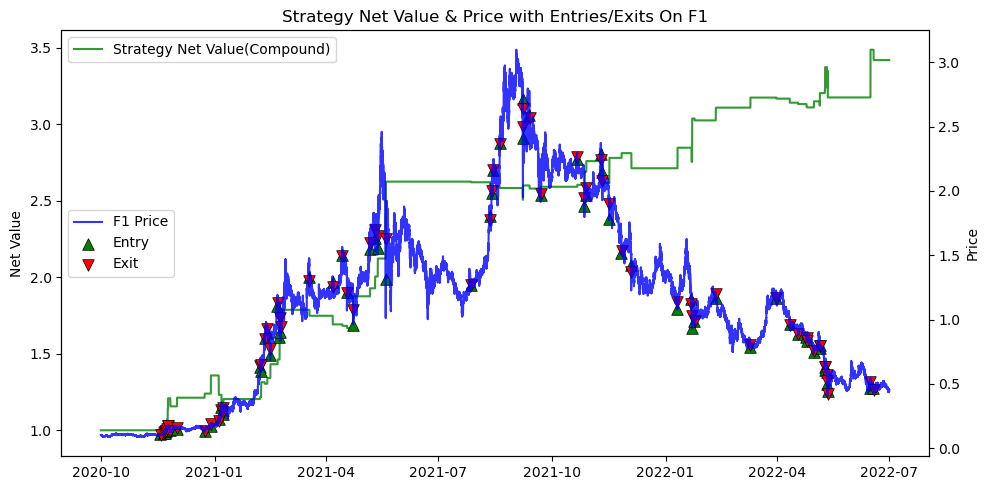

In [84]:
bt_8_2.plot_equity_and_price(str8_1_res, price_col='close', method='compound')

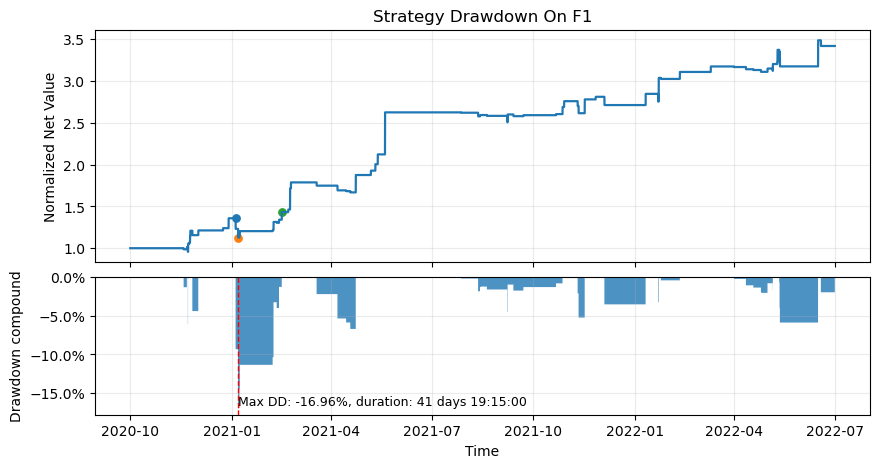

In [85]:
bt_8_2.plot_drawdown(str8_1_res, method='compound')

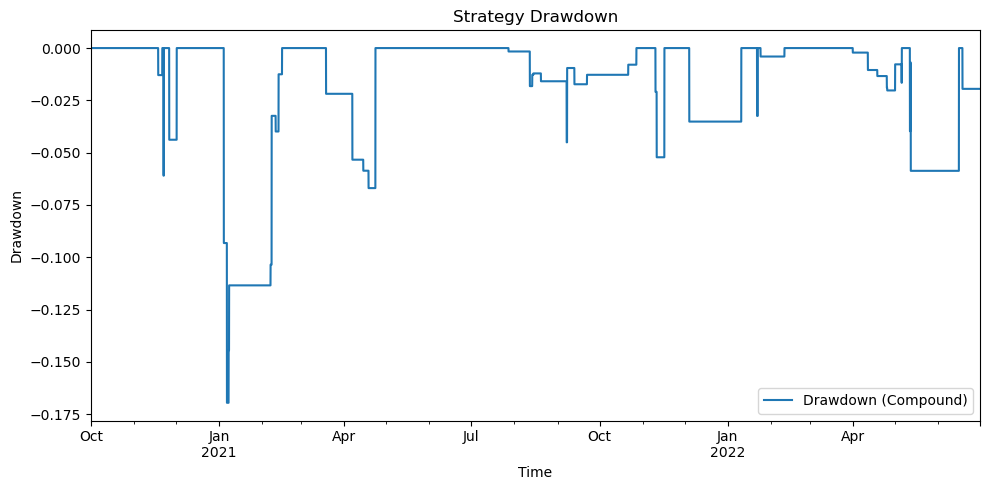

In [86]:
bt_8_2.plot_drawdown_simple(str8_1_res, method='compound')

# Test Same Strategy On Multiple Asset

In [25]:
import os

# Directory containing the CSV files
directory = r'D:\CTA\k线数据\data5m'
# list to store data
data_list = []
# Read each CSV file
file_list = os.listdir(directory)
for filename in sorted(file_list, key=lambda x :(x[2], x in file_list)):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        print(filename)
        dl = DataLoader(
                    filepath= file_path,      # or .parquet
                    date_col= "open_time",                 # column with timestamps
                    cols_to_keep=None,          # we only need close for Strategy8
                    unit= 'ms',                    # e.g., 'ms' if date_col is in milliseconds since epoch; optional
                    tz=None,
                    expected_freq="5T"               # e.g., 5-minute data; optional
                )
        df = dl.load()
        print({k: df.attrs[k] for k in ['expected_freq','n_duplicate_index_dropped','n_bad_intervals']})
        df['avg_price'] = 0.25*(df['open'] + df['high'] + df['low'] + df['close'])
        data_list.append(df)

F1-2y.csv
{'expected_freq': '5T', 'n_duplicate_index_dropped': 25701, 'n_bad_intervals': 796}
F2-2y.csv
{'expected_freq': '5T', 'n_duplicate_index_dropped': 17040, 'n_bad_intervals': 531}
F3-2y.csv
{'expected_freq': '5T', 'n_duplicate_index_dropped': 25701, 'n_bad_intervals': 796}
F4-2y.csv
{'expected_freq': '5T', 'n_duplicate_index_dropped': 25701, 'n_bad_intervals': 796}
F5-2y.csv
{'expected_freq': '5T', 'n_duplicate_index_dropped': 25701, 'n_bad_intervals': 796}
F6-2y.csv
{'expected_freq': '5T', 'n_duplicate_index_dropped': 25701, 'n_bad_intervals': 796}
F7-2y.csv
{'expected_freq': '5T', 'n_duplicate_index_dropped': 17040, 'n_bad_intervals': 531}
F8-2y.csv
{'expected_freq': '5T', 'n_duplicate_index_dropped': 25701, 'n_bad_intervals': 796}
F9-2y.csv
{'expected_freq': '5T', 'n_duplicate_index_dropped': 17040, 'n_bad_intervals': 531}
F10-2y.csv
{'expected_freq': '5T', 'n_duplicate_index_dropped': 25701, 'n_bad_intervals': 796}
F11-2y.csv
{'expected_freq': '5T', 'n_duplicate_index_dropp

In [26]:
file_list = sorted(file_list, key=lambda x :(x[2], x in file_list))
assets_names = [f.split('-')[0] for f in file_list if f.endswith('.csv')]
assets_names

['F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'F9',
 'F10',
 'F11',
 'F12',
 'F13',
 'F14',
 'F15',
 'F16',
 'F17',
 'F18']

In [ ]:
# Create the assets dict with asset name as key and tuple of (asset df , the same port) as value
assets = {}
for name, df in zip(assets_names, data_list):
    assets[name] = (df, port_8_2)

In [28]:
board, res_by_asset = Backtester.run_strategy_on_assets(
    strategy=str8_2,
    assets=assets,
    periods_per_year=252*24*12,
    name="MeanReversionCTA8.2"
)

In [29]:
board

,CAGR_add,CAGR_comp,AnnReturn,AnnVol,Sharpe,MaxDD_add,MaxDD_comp,AvgTurnover,NumTrades,WinRate,AvgWin,AvgLoss,PnlRatio,MaxSingleLoss
asset,,,,,,,,,,,,,,
F1,0.727749,1.948475,1.181962,0.487117,2.364859,-0.013517,-0.021861,0.000316,29,0.931034,0.112182,-0.018237,6.151474,-0.021861
F2,0.152793,0.179365,0.182439,0.147071,1.036496,0.000000,0.000000,0.000062,6,1.000000,0.080721,NaN,NaN,NaN
F3,0.375950,0.558206,0.491120,0.336641,1.369769,-0.008972,-0.020311,0.000109,10,0.900000,0.140411,-0.020311,6.913220,-0.020311
F4,0.603986,1.280361,0.911466,0.454679,1.938655,-0.022468,-0.068152,0.000218,20,0.950000,0.125040,-0.068152,1.834729,-0.068152
F5,0.565968,1.072938,0.834486,0.469362,1.714000,-0.339470,-0.431146,0.000490,45,0.733333,0.091741,-0.076228,1.203506,-0.261116
F6,0.513486,0.952147,0.732828,0.381377,1.842871,-0.052218,-0.138357,0.000261,24,0.791667,0.107937,-0.039094,2.760967,-0.078918
F7,0.453921,0.846123,0.688627,0.325494,2.023467,-0.000143,-0.000193,0.000197,19,0.947368,0.101573,-0.000193,527.603636,-0.000193
F8,0.732382,1.977280,1.192692,0.480612,2.419192,-0.042226,-0.081460,0.000327,30,0.866667,0.124801,-0.056305,2.216497,-0.081460
F9,0.842102,2.492213,1.536509,0.743724,2.025628,-0.160653,-0.310926,0.000343,30,0.900000,0.149644,-0.111096,1.346973,-0.279012


In [30]:
board.WinRate.mean()

0.8696091375701829

In [31]:
board.MaxDD_comp.mean(), board.MaxDD_add.mean()


(-0.12120516124962238, -0.06373530101144974)

In [32]:
board.Sharpe.mean()

1.942086496929679

In [33]:
board.PnlRatio.mean()

33.97846142761675

In [34]:
start = min([df.index[0] for df in data_list])
end = max([df.index[-1] for df in data_list])
start, end
#res_by_asset['F1']['ledger']

(Timestamp('2020-10-01 00:00:00'), Timestamp('2022-08-31 23:50:00'))

In [35]:
idx = pd.date_range(start=start, end=end, freq='5min', inclusive='both')
aligned_add = {}
aligned_comp = {}
for name, ledger in [(n, res_by_asset[n]['ledger']) for n in assets_names]:
    a = ledger['equity_additive'].reindex(idx).ffill()
    c = ledger['equity_compound'].reindex(idx).ffill()
    first = a.first_valid_index()
    last  = a.last_valid_index()
    a = a.where((a.index >= first) & (a.index <= last))
    c = c.where((c.index >= first) & (c.index <= last))
    aligned_add[name] = a
    aligned_comp[name] = c

aligned_add_df = pd.DataFrame(aligned_add, index=idx)    
aligned_add_df = aligned_add_df.fillna(1)
aligned_comp_df = pd.DataFrame(aligned_comp, index=idx)
aligned_comp_df = aligned_comp_df.fillna(1)
aligned_add_df, aligned_comp_df


(                           F1        F2        F3        F4        F5  \
 2020-10-01 00:00:00  1.000000  1.000000  1.000000  1.000000  1.000000   
 2020-10-01 00:05:00  1.000000  1.000000  1.000000  1.000000  1.000000   
 2020-10-01 00:10:00  1.000000  1.000000  1.000000  1.000000  1.000000   
 2020-10-01 00:15:00  1.000000  1.000000  1.000000  1.000000  1.000000   
 2020-10-01 00:20:00  1.000000  1.000000  1.000000  1.000000  1.000000   
 ...                       ...       ...       ...       ...       ...   
 2022-08-31 23:30:00  3.992429  1.484326  2.243391  3.307601  3.112706   
 2022-08-31 23:35:00  3.992429  1.484326  2.243391  3.307601  3.112706   
 2022-08-31 23:40:00  3.992429  1.484326  2.243391  3.307601  3.112706   
 2022-08-31 23:45:00  3.992429  1.484326  2.243391  3.307601  3.112706   
 2022-08-31 23:50:00  3.992429  1.484326  2.243391  3.307601  3.112706   
 
                            F6        F7        F8        F9     F10       F11  \
 2020-10-01 00:00:00  1.0000

In [36]:
# Calculate the equally-weighted portfolio returns
ew_add = aligned_add_df.mean(axis=1)
ew_comp = aligned_comp_df.mean(axis=1)
# calculate equally-weighted drawdown
def calculate_drawdown(equity_series):
    rolling_max = equity_series.cummax()
    drawdown = (equity_series - rolling_max) / rolling_max
    return drawdown
ew_add_drawdown = calculate_drawdown(ew_add)
ew_comp_drawdown = calculate_drawdown(ew_comp)
min(ew_add_drawdown), min(ew_comp_drawdown)

(-0.023995068627833273, -0.07943969434138691)

<Axes: title={'center': 'Equally-weighted Additive Equity Curve'}>

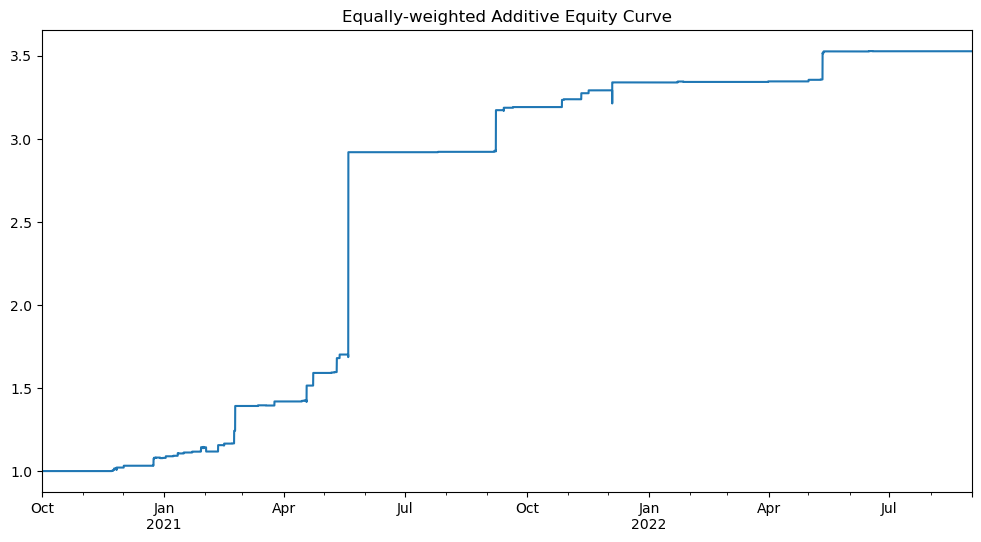

In [37]:
ew_add.plot(title='Equally-weighted Additive Equity Curve', figsize=(12,6))

<Axes: title={'center': 'Equally-weighted Compound Equity Curve'}>

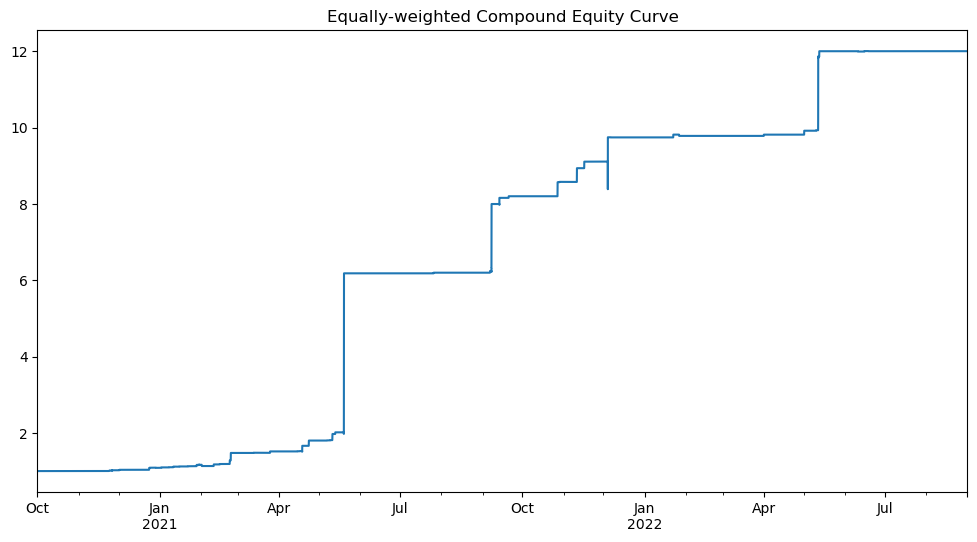

In [38]:
ew_comp.plot(title='Equally-weighted Compound Equity Curve', figsize=(12,6))

In [616]:
res_by_asset['F1']['ledger']

,price,position,turnover,ret_asset,cost_rate,ret_net,equity_additive,drawdown_additive,equity_compound,drawdown_compound
open_time,,,,,,,,,,
2020-10-01 00:00:00,0.101433,0.0,0.0,0.000000,0.0,0.0,1.000000,0.000000,1.000000,0.000000
2020-10-01 00:00:00,0.101433,0.0,0.0,0.000000,0.0,0.0,1.000000,0.000000,1.000000,0.000000
2020-10-01 00:05:00,0.101333,0.0,0.0,-0.000986,0.0,0.0,1.000000,0.000000,1.000000,0.000000
2020-10-01 00:10:00,0.101422,0.0,0.0,0.000888,0.0,0.0,1.000000,0.000000,1.000000,0.000000
2020-10-01 00:15:00,0.102098,0.0,0.0,0.006655,0.0,0.0,1.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2022-06-30 23:30:00,0.445875,0.0,0.0,0.004562,0.0,0.0,4.605952,-0.027158,26.537347,-0.133079
2022-06-30 23:35:00,0.447425,0.0,0.0,0.003476,0.0,0.0,4.605952,-0.027158,26.537347,-0.133079
2022-06-30 23:40:00,0.447550,0.0,0.0,0.000279,0.0,0.0,4.605952,-0.027158,26.537347,-0.133079
